# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 7.27KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

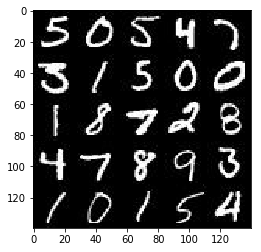

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

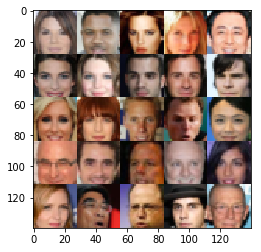

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    # * Real input images placeholder with rank 4 using image_width, image_height, and image_channels
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    
    # * Z input placeholder with rank 2 using z_dim
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    # * Learning rate placeholder with rank 0
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # LAYER 1 - INPUT LAYER
        # input size: 28x28x3
        # output size: 14x14x64
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)  # leaky ReLU
        
        
        # LAYER 2
        # input size: 14x14x64
        # output size: 7x7x128
        x2 = tf.layers.conv2d(inputs=relu1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)  # batch normalization
        relu2 = tf.maximum(alpha * bn2, bn2)  # leaky ReLU
        
        
        # LAYER 3
        # Input size: 7x7x128
        # Output size: 4x4x256
        x3 = tf.layers.conv2d(inputs=relu2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)  # batch normalization
        relu3 = tf.maximum(alpha * bn3, bn3)  # leaky ReLU
        

        # FLATTEN IT
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)  # sigmoid output
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)  # tanh output
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    # TODO: Build Model
    image_shape = data_shape[1:]    
    
    # * Use model_inputs(image_width, image_height, image_channels, z_dim)
    input_real, input_z, lr_rate = model_inputs(*image_shape, z_dim)
    
    # * Use model_loss(input_real, input_z, out_channel_dim)
    out_channel_dim = image_shape[-1]
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    # * Use model_opt(d_loss, g_loss, learning_rate, beta1)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_rate, beta1)
    
    n_images = 25  # Number of images to display
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2 # turn(-0.5, 0.5) into (-1, 1) for Tanh activation functions
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_rate:learning_rate})

                if steps % 10 == 0:  # Print losses every 10 batches
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                
                if steps % 100 == 0:  # Show generated images every 100 batches
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4875... Generator Loss: 1.1673
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 0.7113
Epoch 1/2... Discriminator Loss: 3.6898... Generator Loss: 0.0516
Epoch 1/2... Discriminator Loss: 0.6425... Generator Loss: 3.3463
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 5.4565
Epoch 1/2... Discriminator Loss: 0.5774... Generator Loss: 1.2036
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 2.7358
Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 2.0499
Epoch 1/2... Discriminator Loss: 0.5432... Generator Loss: 1.9159
Epoch 1/2... Discriminator Loss: 0.5269... Generator Loss: 1.8347


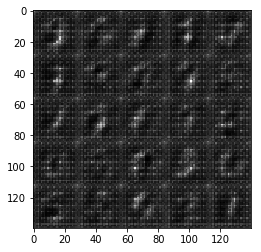

Epoch 1/2... Discriminator Loss: 0.4958... Generator Loss: 2.2918
Epoch 1/2... Discriminator Loss: 0.5839... Generator Loss: 1.7152
Epoch 1/2... Discriminator Loss: 0.9476... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 0.8398... Generator Loss: 2.1013
Epoch 1/2... Discriminator Loss: 0.6130... Generator Loss: 1.7025
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 0.6819
Epoch 1/2... Discriminator Loss: 0.6664... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 2.2972
Epoch 1/2... Discriminator Loss: 0.7066... Generator Loss: 1.0182
Epoch 1/2... Discriminator Loss: 0.6393... Generator Loss: 2.0466


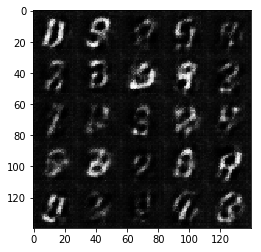

Epoch 1/2... Discriminator Loss: 0.6774... Generator Loss: 1.0202
Epoch 1/2... Discriminator Loss: 0.7826... Generator Loss: 3.3675
Epoch 1/2... Discriminator Loss: 0.5748... Generator Loss: 1.6974
Epoch 1/2... Discriminator Loss: 0.6757... Generator Loss: 2.8679
Epoch 1/2... Discriminator Loss: 0.5201... Generator Loss: 1.9952
Epoch 1/2... Discriminator Loss: 0.5111... Generator Loss: 1.3828
Epoch 1/2... Discriminator Loss: 0.5351... Generator Loss: 1.5900
Epoch 1/2... Discriminator Loss: 0.5354... Generator Loss: 1.6682
Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 1.4444
Epoch 1/2... Discriminator Loss: 0.6422... Generator Loss: 1.0310


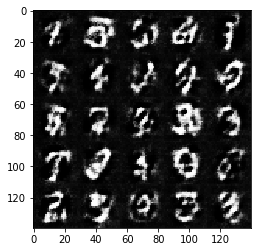

Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.4038
Epoch 1/2... Discriminator Loss: 1.3741... Generator Loss: 0.3744
Epoch 1/2... Discriminator Loss: 0.5135... Generator Loss: 1.2686
Epoch 1/2... Discriminator Loss: 0.5027... Generator Loss: 1.5427
Epoch 1/2... Discriminator Loss: 0.5348... Generator Loss: 1.7106
Epoch 1/2... Discriminator Loss: 0.4841... Generator Loss: 1.5395
Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 1.2960
Epoch 1/2... Discriminator Loss: 0.5558... Generator Loss: 1.4018
Epoch 1/2... Discriminator Loss: 0.4973... Generator Loss: 1.6579
Epoch 1/2... Discriminator Loss: 0.5299... Generator Loss: 2.8583


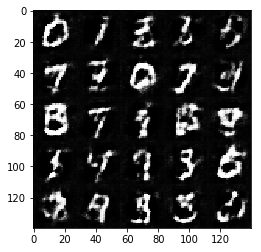

Epoch 1/2... Discriminator Loss: 0.5909... Generator Loss: 1.1266
Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 0.5299
Epoch 1/2... Discriminator Loss: 0.5629... Generator Loss: 1.1367
Epoch 1/2... Discriminator Loss: 0.5991... Generator Loss: 1.6680
Epoch 1/2... Discriminator Loss: 0.5021... Generator Loss: 1.4064
Epoch 1/2... Discriminator Loss: 2.2299... Generator Loss: 0.1546
Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 0.6127
Epoch 1/2... Discriminator Loss: 0.6953... Generator Loss: 2.1655
Epoch 1/2... Discriminator Loss: 0.5610... Generator Loss: 1.7423
Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.4014


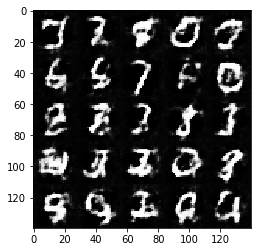

Epoch 1/2... Discriminator Loss: 0.5145... Generator Loss: 1.6265
Epoch 1/2... Discriminator Loss: 0.7873... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 0.6415... Generator Loss: 1.1169
Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 0.4126
Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 2.2866
Epoch 1/2... Discriminator Loss: 1.0565... Generator Loss: 0.5390
Epoch 1/2... Discriminator Loss: 0.6175... Generator Loss: 1.5676
Epoch 1/2... Discriminator Loss: 0.6516... Generator Loss: 1.0342
Epoch 1/2... Discriminator Loss: 1.7892... Generator Loss: 0.2664
Epoch 1/2... Discriminator Loss: 0.6837... Generator Loss: 1.2873


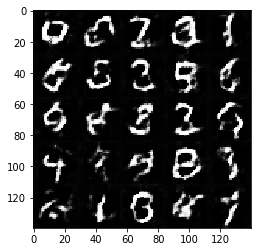

Epoch 1/2... Discriminator Loss: 0.7572... Generator Loss: 2.6154
Epoch 1/2... Discriminator Loss: 0.5549... Generator Loss: 1.6978
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.5701
Epoch 1/2... Discriminator Loss: 0.5543... Generator Loss: 1.2711
Epoch 1/2... Discriminator Loss: 0.5710... Generator Loss: 1.2700
Epoch 1/2... Discriminator Loss: 0.7163... Generator Loss: 1.5205
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 0.7595
Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 0.8783
Epoch 1/2... Discriminator Loss: 0.6372... Generator Loss: 1.6367
Epoch 1/2... Discriminator Loss: 0.9505... Generator Loss: 0.6441


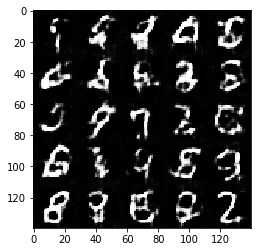

Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 1.1056
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 0.4350
Epoch 1/2... Discriminator Loss: 0.7199... Generator Loss: 0.9216
Epoch 1/2... Discriminator Loss: 1.1685... Generator Loss: 0.4934
Epoch 1/2... Discriminator Loss: 0.8357... Generator Loss: 1.2687
Epoch 1/2... Discriminator Loss: 0.7031... Generator Loss: 1.1204
Epoch 1/2... Discriminator Loss: 0.6884... Generator Loss: 1.3496
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 0.5337
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 1.3540
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 0.6066


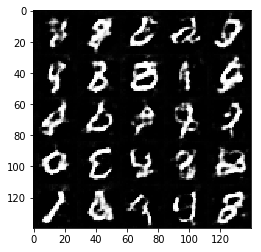

Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 0.7315
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 1.5058
Epoch 1/2... Discriminator Loss: 0.6748... Generator Loss: 1.6487
Epoch 1/2... Discriminator Loss: 0.8015... Generator Loss: 0.8484
Epoch 1/2... Discriminator Loss: 1.5923... Generator Loss: 0.3405
Epoch 1/2... Discriminator Loss: 1.0088... Generator Loss: 0.6429
Epoch 1/2... Discriminator Loss: 0.6112... Generator Loss: 1.1380
Epoch 1/2... Discriminator Loss: 0.8582... Generator Loss: 0.7398
Epoch 1/2... Discriminator Loss: 0.6267... Generator Loss: 1.5553
Epoch 1/2... Discriminator Loss: 0.8560... Generator Loss: 0.7340


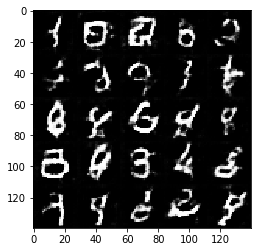

Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 0.5988
Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 0.6052
Epoch 1/2... Discriminator Loss: 0.4596... Generator Loss: 1.4577
Epoch 2/2... Discriminator Loss: 0.7480... Generator Loss: 1.0393
Epoch 2/2... Discriminator Loss: 0.7416... Generator Loss: 0.9350
Epoch 2/2... Discriminator Loss: 0.6283... Generator Loss: 1.2029
Epoch 2/2... Discriminator Loss: 0.6275... Generator Loss: 1.0602
Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 1.6188
Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 1.3692
Epoch 2/2... Discriminator Loss: 0.5829... Generator Loss: 1.8688


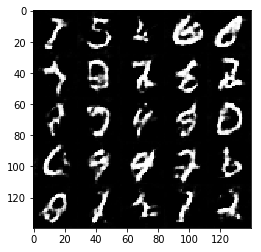

Epoch 2/2... Discriminator Loss: 0.4335... Generator Loss: 1.8010
Epoch 2/2... Discriminator Loss: 1.4097... Generator Loss: 0.4193
Epoch 2/2... Discriminator Loss: 0.6896... Generator Loss: 0.9583
Epoch 2/2... Discriminator Loss: 0.9467... Generator Loss: 0.7222
Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 0.8905
Epoch 2/2... Discriminator Loss: 1.4528... Generator Loss: 0.3549
Epoch 2/2... Discriminator Loss: 0.6064... Generator Loss: 1.3791
Epoch 2/2... Discriminator Loss: 0.8342... Generator Loss: 0.7885
Epoch 2/2... Discriminator Loss: 0.5137... Generator Loss: 1.2395
Epoch 2/2... Discriminator Loss: 0.6742... Generator Loss: 1.6431


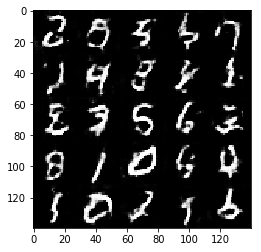

Epoch 2/2... Discriminator Loss: 2.8946... Generator Loss: 4.1950
Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 0.6236
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.3755
Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 1.1724
Epoch 2/2... Discriminator Loss: 0.5782... Generator Loss: 1.1448
Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 0.9956
Epoch 2/2... Discriminator Loss: 1.5255... Generator Loss: 0.4145
Epoch 2/2... Discriminator Loss: 0.6224... Generator Loss: 1.3613
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 1.8707
Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 0.4503


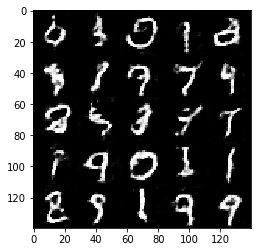

Epoch 2/2... Discriminator Loss: 0.7060... Generator Loss: 1.1743
Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 0.9644
Epoch 2/2... Discriminator Loss: 0.6050... Generator Loss: 1.1888
Epoch 2/2... Discriminator Loss: 0.7450... Generator Loss: 0.9051
Epoch 2/2... Discriminator Loss: 0.7049... Generator Loss: 1.1064
Epoch 2/2... Discriminator Loss: 0.6432... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 0.6722
Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 0.5294
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.4161
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 0.7441


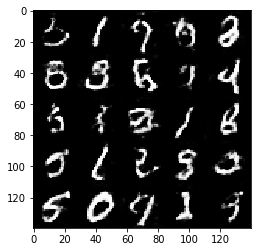

Epoch 2/2... Discriminator Loss: 0.5428... Generator Loss: 1.4342
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 0.8790
Epoch 2/2... Discriminator Loss: 0.7252... Generator Loss: 0.9343
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 0.8861
Epoch 2/2... Discriminator Loss: 0.5620... Generator Loss: 1.2102
Epoch 2/2... Discriminator Loss: 1.0396... Generator Loss: 2.5280
Epoch 2/2... Discriminator Loss: 0.6212... Generator Loss: 1.0990
Epoch 2/2... Discriminator Loss: 2.1937... Generator Loss: 0.2158
Epoch 2/2... Discriminator Loss: 0.7274... Generator Loss: 1.4030
Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 1.0043


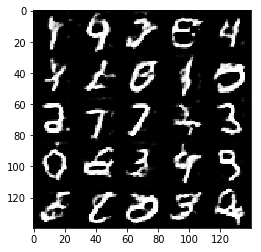

Epoch 2/2... Discriminator Loss: 0.6041... Generator Loss: 1.7511
Epoch 2/2... Discriminator Loss: 0.7361... Generator Loss: 0.9915
Epoch 2/2... Discriminator Loss: 0.6511... Generator Loss: 1.6755
Epoch 2/2... Discriminator Loss: 1.4788... Generator Loss: 0.3271
Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 1.2827
Epoch 2/2... Discriminator Loss: 0.5934... Generator Loss: 1.3321
Epoch 2/2... Discriminator Loss: 0.6691... Generator Loss: 1.0051
Epoch 2/2... Discriminator Loss: 0.5891... Generator Loss: 1.7832
Epoch 2/2... Discriminator Loss: 0.6875... Generator Loss: 1.0890
Epoch 2/2... Discriminator Loss: 0.8431... Generator Loss: 1.3536


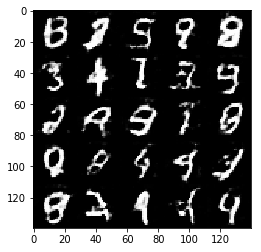

Epoch 2/2... Discriminator Loss: 0.5671... Generator Loss: 1.2099
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 0.8567
Epoch 2/2... Discriminator Loss: 1.0905... Generator Loss: 0.5358
Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 2.2146
Epoch 2/2... Discriminator Loss: 0.7957... Generator Loss: 0.8667
Epoch 2/2... Discriminator Loss: 0.7289... Generator Loss: 0.8878
Epoch 2/2... Discriminator Loss: 2.3798... Generator Loss: 0.1634
Epoch 2/2... Discriminator Loss: 0.6811... Generator Loss: 1.7433
Epoch 2/2... Discriminator Loss: 0.7972... Generator Loss: 2.1978
Epoch 2/2... Discriminator Loss: 1.6973... Generator Loss: 0.2777


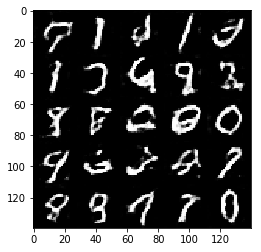

Epoch 2/2... Discriminator Loss: 0.4685... Generator Loss: 1.8331
Epoch 2/2... Discriminator Loss: 0.5784... Generator Loss: 1.2259
Epoch 2/2... Discriminator Loss: 0.9153... Generator Loss: 0.6541
Epoch 2/2... Discriminator Loss: 0.6278... Generator Loss: 0.9982
Epoch 2/2... Discriminator Loss: 0.9529... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 0.7153... Generator Loss: 1.0119
Epoch 2/2... Discriminator Loss: 0.7616... Generator Loss: 1.3046
Epoch 2/2... Discriminator Loss: 6.2237... Generator Loss: 9.2432
Epoch 2/2... Discriminator Loss: 0.8020... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 0.6494... Generator Loss: 2.0681


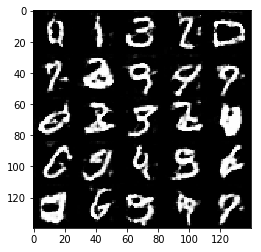

Epoch 2/2... Discriminator Loss: 0.6349... Generator Loss: 1.8306
Epoch 2/2... Discriminator Loss: 0.6075... Generator Loss: 1.4381
Epoch 2/2... Discriminator Loss: 0.6344... Generator Loss: 1.0584
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 0.6956
Epoch 2/2... Discriminator Loss: 0.4720... Generator Loss: 1.9074
Epoch 2/2... Discriminator Loss: 0.5761... Generator Loss: 1.0447
Epoch 2/2... Discriminator Loss: 1.2295... Generator Loss: 0.4576
Epoch 2/2... Discriminator Loss: 0.7402... Generator Loss: 0.9475
Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 3.3399
Epoch 2/2... Discriminator Loss: 0.5611... Generator Loss: 1.4221


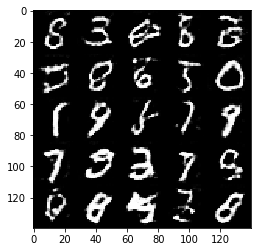

Epoch 2/2... Discriminator Loss: 0.6355... Generator Loss: 1.1044
Epoch 2/2... Discriminator Loss: 0.5217... Generator Loss: 1.3048
Epoch 2/2... Discriminator Loss: 0.4875... Generator Loss: 1.3459
Epoch 2/2... Discriminator Loss: 0.9069... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 0.6727... Generator Loss: 2.4230
Epoch 2/2... Discriminator Loss: 0.7540... Generator Loss: 0.8827
Epoch 2/2... Discriminator Loss: 0.7803... Generator Loss: 0.7963


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5693... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 0.7064... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 0.1629... Generator Loss: 3.5001
Epoch 1/1... Discriminator Loss: 0.1106... Generator Loss: 2.8961
Epoch 1/1... Discriminator Loss: 0.1090... Generator Loss: 2.7508
Epoch 1/1... Discriminator Loss: 3.0469... Generator Loss: 10.0163
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 7.2287
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 1.6263
Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 1.3454


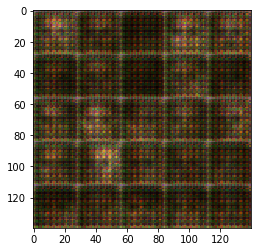

Epoch 1/1... Discriminator Loss: 0.5192... Generator Loss: 1.5526
Epoch 1/1... Discriminator Loss: 0.2992... Generator Loss: 2.7069
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 3.1883
Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 1.4554
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 4.8128
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.7737
Epoch 1/1... Discriminator Loss: 0.3387... Generator Loss: 2.5779
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 1.3082
Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 0.9420


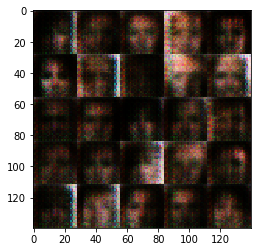

Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 3.6699
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 1.2772
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 3.1895
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 2.3735
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 1.9815
Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 1.6922
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.9171


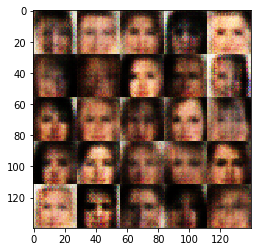

Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 1.5213
Epoch 1/1... Discriminator Loss: 0.7595... Generator Loss: 1.5587
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 0.3348
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.2997
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 2.2325
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.5202


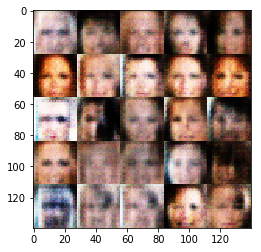

Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 1.9703
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 2.1648
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 1.2642
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 2.0668


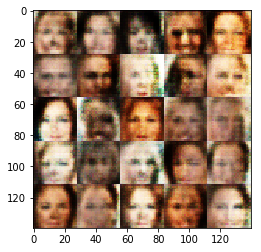

Epoch 1/1... Discriminator Loss: 0.6590... Generator Loss: 1.9900
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.3928
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 2.0770
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.7679
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 1.0476


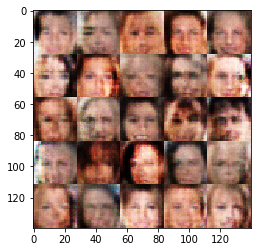

Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 1.2937
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.4037
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 1.3451
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.3004
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.3196


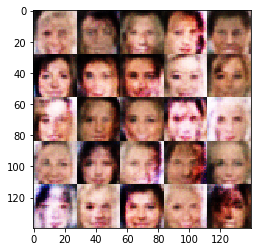

Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 1.5331
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.3697


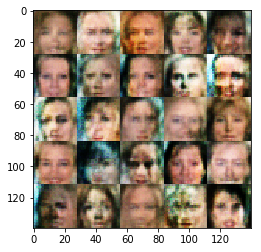

Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.8616
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.6598
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.2742
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.4350
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 1.1735


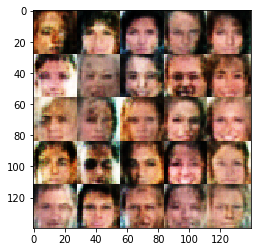

Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 1.5021
Epoch 1/1... Discriminator Loss: 0.7413... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 1.9518
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.6456
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.1727


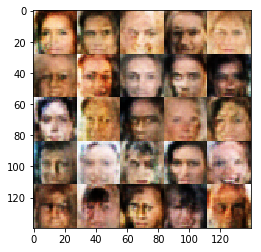

Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 1.2903
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.6066
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.4934


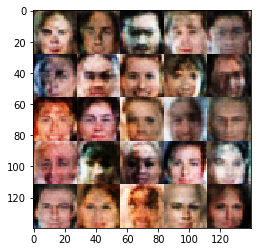

Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.2358
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.3332
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.8656


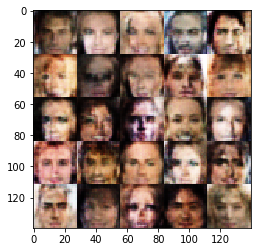

Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.6704
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 1.7321
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 1.4202
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.6006
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.6842


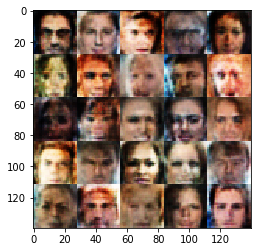

Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.6403
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 1.4845
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.4564
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.4704


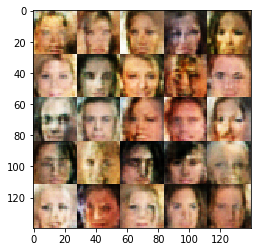

Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.7184
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.0853


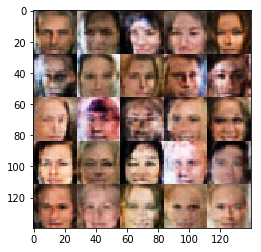

Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 1.6459
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 1.3514
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 1.2367
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.3726
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.2866


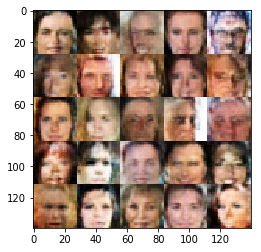

Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.2853
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 1.4346
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.2594
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 1.7468
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 0.9820


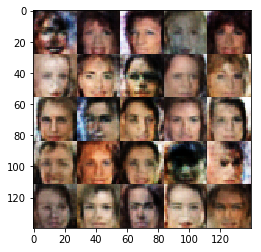

Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 1.9817
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.3606
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 1.2462


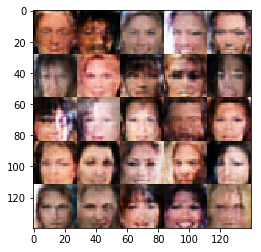

Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 1.1596
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.3926
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 1.1764
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 0.6897


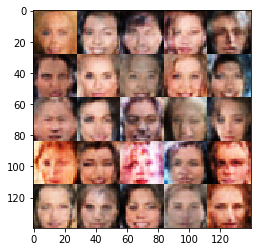

Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.6960... Generator Loss: 0.2760
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.0947
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.4794


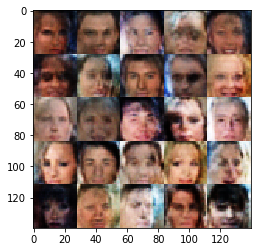

Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.7940
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.8803
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.8968
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 1.6206
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.4608


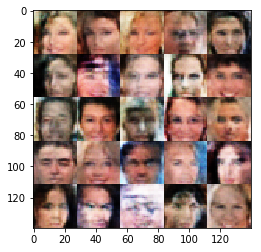

Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.2495
Epoch 1/1... Discriminator Loss: 1.7662... Generator Loss: 0.2834
Epoch 1/1... Discriminator Loss: 0.7036... Generator Loss: 1.3706
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 1.0373


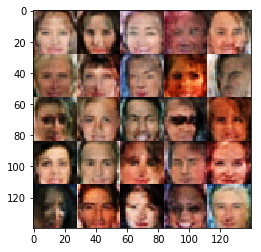

Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 1.7547
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.3596
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.7288


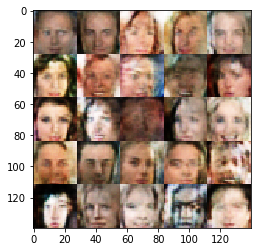

Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.3967
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.9331
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 1.3024


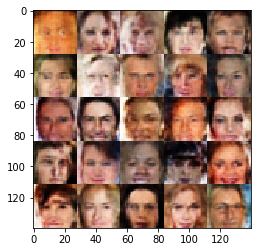

Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 1.2642
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.2145
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.4691


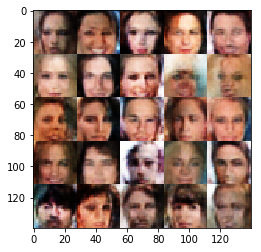

Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.3511
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.5767
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.3358
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 1.4761
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 1.2790


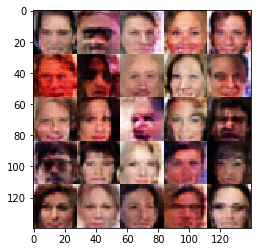

Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.4136
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.3155
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 1.7293


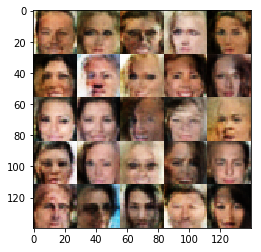

Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 1.9511
Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 1.4462
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.2971
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 1.3913
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.4192


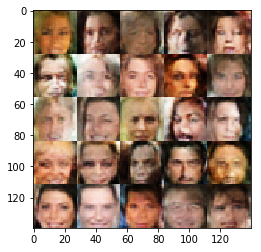

Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 0.9991


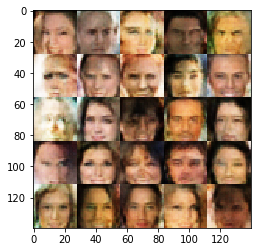

Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 1.6587
Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.2587
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.5710


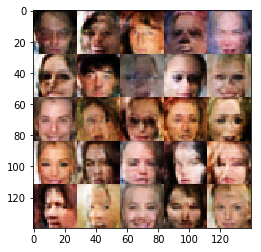

Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.5970
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 1.6787
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 0.8875


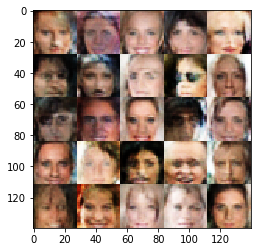

Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.3996
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.0826


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.